# 1. Data Loading and  Exploration



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import string
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as creport


from multiprocessing import Pool

### **Loading Data**

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Updated_Dataset.csv')
train_data.head()

,Tweet,Class
0,وسخ وليس وصخ هاه مين الوسخ فينا يا نجم ...,hate
1,لا تحسبوني نسيتكم يا عبنده يا كويحة يا م...,hate
2,تحرير فلسطين اله رجاله ، وانتوا يا نسل ال...,hate
3,يا لبناني يا فضلات الاستعمار الفرنسي اللب...,hate
4,الخيانه والغدر والعماله من خصالكم نحن من ح...,hate


In [ ]:
print("Train data shape:{}".format(train_data.shape))

Train data shape:(2519, 2)


### **Checking Missing Values**

In [ ]:
train_data.isnull().sum()

Tweet    0
Class    0
dtype: int64

There are no missing values in both train and dev dataset.

### **Class distribution in L-HSAB dataset**

In [ ]:
train_data['Class'].value_counts()

normal     861
abusive    829
hate       829
Name: Class, dtype: int64

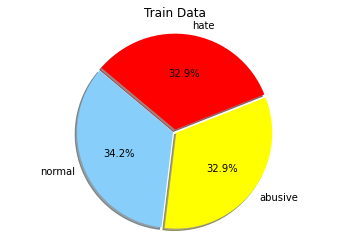

In [ ]:
# Data to plot
labels = "normal", "abusive", "hate" 
sizes = [train_data['Class'].value_counts()[0], train_data['Class'].value_counts()[1], train_data['Class'].value_counts()[2]]
colors = ['lightskyblue', 'yellow', "red"]
explode = (0.02,0.02, 0.02) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Train Data")
plt.show()

# 2. Data Cleaning
To prepare our dataset for the feature extraction process, basic text preprocessing is done as follows:

In [ ]:
def clean(df):
    df = remove_diacritics(df)
    df = normalize_arabic(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df= remove_english_word_and_numbers(df)
    df=clean_space(df)
    return df

In [ ]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [ ]:
def remove_diacritics(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x

def remove_punctuations(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_punctuations(x))
    return df
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_repeating_char(x))
    return df
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['Tweet'] = df["Tweet"].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)


In [ ]:
num_cores = 2
def df_parallelize_run(df, func, num_cores=2):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
train_data_cleaned = df_parallelize_run(train_data, clean)

In [ ]:
train_data_cleaned.to_csv("train_data_cleaned.csv", index=False)    #save the train_data_cleaned dataframe to csv

In [ ]:
!cp -R train_data_cleaned.csv "/content/drive/My Drive/OSACT4"            #save the csv file to the drive

# 3. tf- idf
We experimented with various classical machine learning models:

1.  SVM
2.  Random Forest
3.  XGBoost
4.  Extra Trees
5.  Decision Trees
6.  Gradient Boosting
7.  Logistic Regression









In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/OSACT4')

In [ ]:
dataset.head()

,Tweet,Class
0,وسخ وليس وصخ هاه مين الوسخ فينا يا نجم يا ساح...,hate
1,لا تحسبوني نسيتكم يا عبنده يا كويحه يا ملطشه ...,hate
2,تحرير فلسطين اله رجاله وانتوا يا نسل البنجال ...,hate
3,يا لبناني يا فضلات الاستعمار الفرنسي البنانين...,hate
4,الخيانه والغدر والعماله من خصالكم نحن من حارب...,hate


In [ ]:
x=dataset.iloc[:,0]
y=dataset.iloc[:,1]
X=x.to_dict()

X=[]
for d in range(len(x)):
    b=x[d]
    X.append(b) 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
count_vect=CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf= X_train_tfidf.toarray()

In [ ]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf= X_test_tfidf.toarray()

In [ ]:
print(X_train_tfidf.shape, X_test_tfidf.shape)

(2015, 10543) (504, 10543)



## SVM Classifier

In [ ]:
from sklearn.svm import SVC
clf= SVC(random_state = 0)
clf.fit(X_train_tfidf, y_train)
clf.score(X_train_tfidf, y_train)

0.9945409429280397

In [ ]:
y_pred = clf.predict(X_test_tfidf)

In [ ]:
y_test

2197     normal
410      normal
1389    abusive
888        hate
1774       hate
         ...   
862      normal
1817       hate
51         hate
1940       hate
495        hate
Name: Class, Length: 504, dtype: object

In [ ]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.6853    0.5665    0.6203       173
     abusive     0.7203    0.6319    0.6732       163
        hate     0.6560    0.8512    0.7409       168

    accuracy                         0.6825       504
   macro avg     0.6872    0.6832    0.6781       504
weighted avg     0.6868    0.6825    0.6776       504



## Random Forest Classifier


In [ ]:
from sklearn import model_selection, naive_bayes, svm, ensemble, tree
from xgboost import XGBClassifier

In [ ]:
RF= ensemble.RandomForestClassifier()
RF.fit(X_train_tfidf, y_train)
RF.score(X_train_tfidf, y_train)

1.0

In [ ]:
y_pred=RF.predict(X_test_tfidf)

In [ ]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.6405    0.5665    0.6012       173
     abusive     0.7724    0.5828    0.6643       163
        hate     0.6184    0.8393    0.7121       168

    accuracy                         0.6627       504
   macro avg     0.6771    0.6629    0.6592       504
weighted avg     0.6758    0.6627    0.6586       504



## XGB Classifier

In [ ]:
XGB= XGBClassifier()
XGB.fit(X_train_tfidf, y_train)
XGB.score(X_train_tfidf, y_train)

0.7290322580645161

In [ ]:
y_pred=XGB.predict(X_test_tfidf)

In [ ]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.6610    0.4509    0.5361       173
     abusive     0.6377    0.5399    0.5847       163
        hate     0.5806    0.8571    0.6923       168

    accuracy                         0.6151       504
   macro avg     0.6264    0.6160    0.6044       504
weighted avg     0.6267    0.6151    0.6039       504



##Extra Trees Classifier

In [ ]:
extrees= ensemble.ExtraTreesClassifier()
extrees.fit(X_train_tfidf, y_train)
extrees.score(X_train_tfidf, y_train)

1.0

In [ ]:
y_pred=extrees.predict(X_test_tfidf)

In [ ]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.6752    0.6127    0.6424       173
     abusive     0.7874    0.6135    0.6897       163
        hate     0.6591    0.8631    0.7474       168

    accuracy                         0.6964       504
   macro avg     0.7072    0.6964    0.6932       504
weighted avg     0.7061    0.6964    0.6927       504



## Decision Tree Classifier

In [ ]:
DTC= tree.DecisionTreeClassifier()
DTC.fit(X_train_tfidf, y_train)
DTC.score(X_train_tfidf, y_train)

1.0

In [ ]:
y_pred=DTC.predict(X_test_tfidf)

In [ ]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.5096    0.4624    0.4848       173
     abusive     0.5924    0.5706    0.5813       163
        hate     0.6158    0.6964    0.6536       168

    accuracy                         0.5754       504
   macro avg     0.5726    0.5765    0.5732       504
weighted avg     0.5717    0.5754    0.5723       504



## Gradient Boosting Classifier

In [ ]:
GBC= ensemble.GradientBoostingClassifier()
GBC.fit(X_train_tfidf, y_train)
GBC.score(X_train_tfidf, y_train)

0.7890818858560794

In [ ]:
y_pred=GBC.predict(X_test_tfidf)

In [ ]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.6512    0.4855    0.5563       173
     abusive     0.6897    0.6135    0.6494       163
        hate     0.6304    0.8631    0.7286       168

    accuracy                         0.6528       504
   macro avg     0.6571    0.6540    0.6448       504
weighted avg     0.6567    0.6528    0.6438       504



## Logistic Regression Classifier

In [ ]:
from sklearn import linear_model

In [ ]:
LR= linear_model.LogisticRegression(multi_class='multinomial')
LR.fit(X_train_tfidf, y_train)
LR.score(X_train_tfidf, y_train)

0.9543424317617866

In [ ]:
y_pred=LR.predict(X_test_tfidf)

In [ ]:
print(creport(y_test, y_pred, target_names=["normal", "abusive", "hate"], digits=4))

              precision    recall  f1-score   support

      normal     0.6711    0.5780    0.6211       173
     abusive     0.6852    0.6810    0.6831       163
        hate     0.7047    0.8095    0.7535       168

    accuracy                         0.6885       504
   macro avg     0.6870    0.6895    0.6859       504
weighted avg     0.6869    0.6885    0.6853       504



In [ ]:
print(X_test[444], y_pred[444])
print(X_test[123], y_pred[123])
print(X_test[100], y_pred[100])
print(X_test[58], y_pred[58])

 لعنت اله عليك يا شارب بول البعير يا عبد امريكا اذهب ابحث عن افريقي 😂 hate
اما انت كا زعيم بي قريه زغرتا بس يسير بدك تمسك تمسك بي رصن الجحش يا جحش abusive
هاد يلي بجيب المسبه لحاله  normal
اكدت اوساط الرءيس الحريري ان الامور تجه نحو الانفراج بعد قبول جبران باسيل ب حل وسط بالنسبه الي مثل القاء normal
